WARNING : MAKE SURE YOU GO THROUGH pytorch_env_install.ipynb IN ORDER TO INSTALL PIPENV AND DEPENDENCIES
Project done on VisualStudio Code, will automatically prompt for necessary extensions
YOU NEED TO INSTALL PYTHON 3.7.9 ON YOUR SYSTEM !



SEE "library_building.ipynb" FIRST BEFORE USING MODEL (Files need to be loaded)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image

print(torch.__version__)

1.10.1+cu113


In [14]:
class SAR_Train_Dataset(Dataset):

    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.main_dir = "./data2"
        self.noiseless_train = "/train_set/train_noiseless_clones/"
        self.noisy_train = "/train_set/train_noisy_clones/"
        self.df_train = pd.read_csv(self.main_dir+"/dataset_mapping_train.csv", sep=',', usecols=['noiseless', 'noisy'])

    def __getitem__(self, index):
        noiseless_train = Image.open(self.main_dir+self.noiseless_train+self.df_train.iloc[index]["noiseless"])
        noisy_train = Image.open(self.main_dir+self.noisy_train+self.df_train.iloc[index]["noisy"])

        noiseless_train = self.transform(noiseless_train)
        noisy_train = self.transform(noisy_train)
        return [noiseless_train, noisy_train]

    def __len__(self):
        return len(self.df_train)

class SAR_Test_Dataset(Dataset):

    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.main_dir = "./data2"
        self.noiseless_test = "/test_set/test_noiseless_clones/"
        self.noisy_test = "/test_set/test_noisy_clones/"
        self.df_test = pd.read_csv(self.main_dir+"/dataset_mapping_test.csv", sep=',', usecols=['noiseless', 'noisy'])

    def __getitem__(self, index):
        noiseless_test = Image.open(self.main_dir+self.noiseless_test+self.df_test.iloc[index]["noiseless"])
        noisy_test = Image.open(self.main_dir+self.noisy_test+self.df_test.iloc[index]["noisy"])

        noiseless_test = self.transform(noiseless_test)
        noisy_test = self.transform(noisy_test)
        return [noiseless_test, noisy_test]

    def __len__(self):
        return len(self.df_test)

train_dataset = SAR_Train_Dataset()

test_dataset = SAR_Test_Dataset()

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True, 
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True, 
)

class AE(nn.Module):
    def __init__(self):
        super().__init__()

        #Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 1, 2, stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        # x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv2(x))
        # x = self.pool(x)
        x = torch.relu(self.t_conv1(x))
        x = self.pool(x)
        x = torch.sigmoid(self.t_conv2(x))
        x = self.pool(x)
              
        return x


In [16]:
torch.cuda.empty_cache()
print(torch.cuda.is_available())


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)
# model = AE()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=0.01)

# mean-squared error loss
criterion = nn.BCELoss()

True


In [17]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 224, 224]          36,928
            Conv2d-3         [-1, 64, 224, 224]          36,928
            Conv2d-4         [-1, 64, 224, 224]          36,928
   ConvTranspose2d-5         [-1, 64, 448, 448]          16,448
         MaxPool2d-6         [-1, 64, 224, 224]               0
   ConvTranspose2d-7          [-1, 1, 448, 448]             257
         MaxPool2d-8          [-1, 1, 224, 224]               0
Total params: 128,129
Trainable params: 128,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 222.41
Params size (MB): 0.49
Estimated Total Size (MB): 223.09
----------------------------------------------------------------


In [18]:
epochs = 10
if torch.cuda.is_available():
    torch.cuda.empty_cache()
outputlist = []
for epoch in range(epochs):
    loss = 0
    for noiseless_imgs, noisy_imgs in train_loader:
        noiseless_imgs = noiseless_imgs.to(device)
        noisy_imgs = noisy_imgs.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(noisy_imgs)
        
        train_loss = criterion(outputs, noiseless_imgs)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    outputlist.append((epoch, noiseless_imgs, noisy_imgs, outputs))
    
    print(f"epoch : {epoch+1}/{epochs}, loss = {loss:6f}")

epoch : 1/10, loss = 0.693038
epoch : 2/10, loss = 0.616327
epoch : 3/10, loss = 0.597228
epoch : 4/10, loss = 0.584148
epoch : 5/10, loss = 0.576398
epoch : 6/10, loss = 0.574487
epoch : 7/10, loss = 0.574802
epoch : 8/10, loss = 0.572426
epoch : 9/10, loss = 0.571420
epoch : 10/10, loss = 0.569666


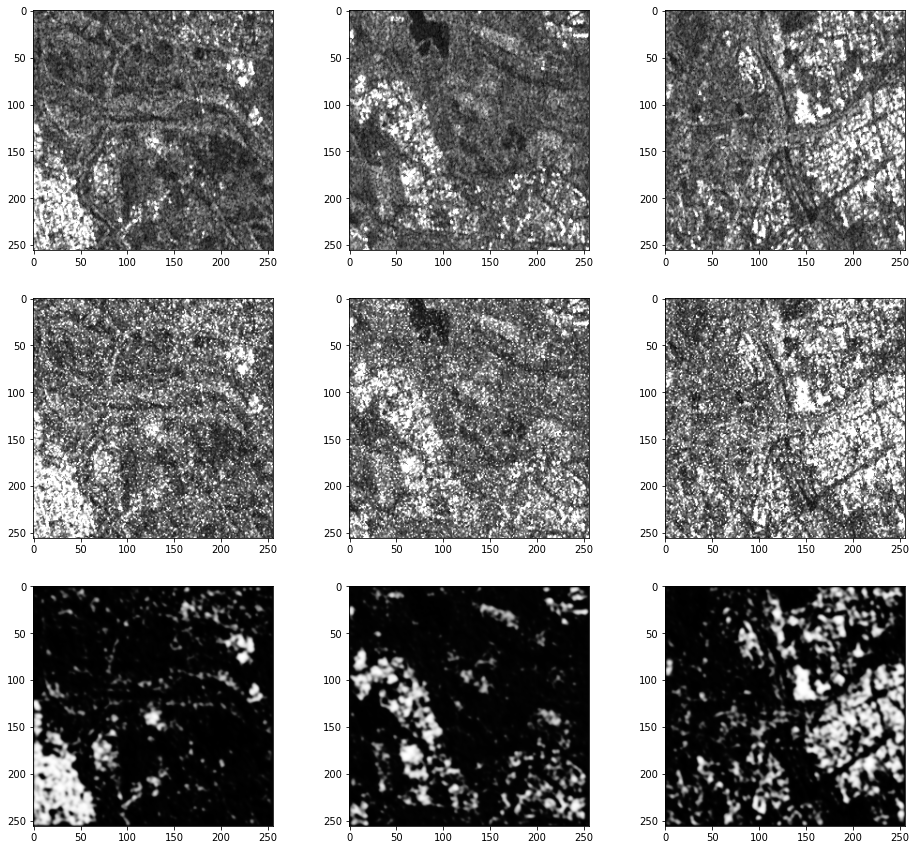

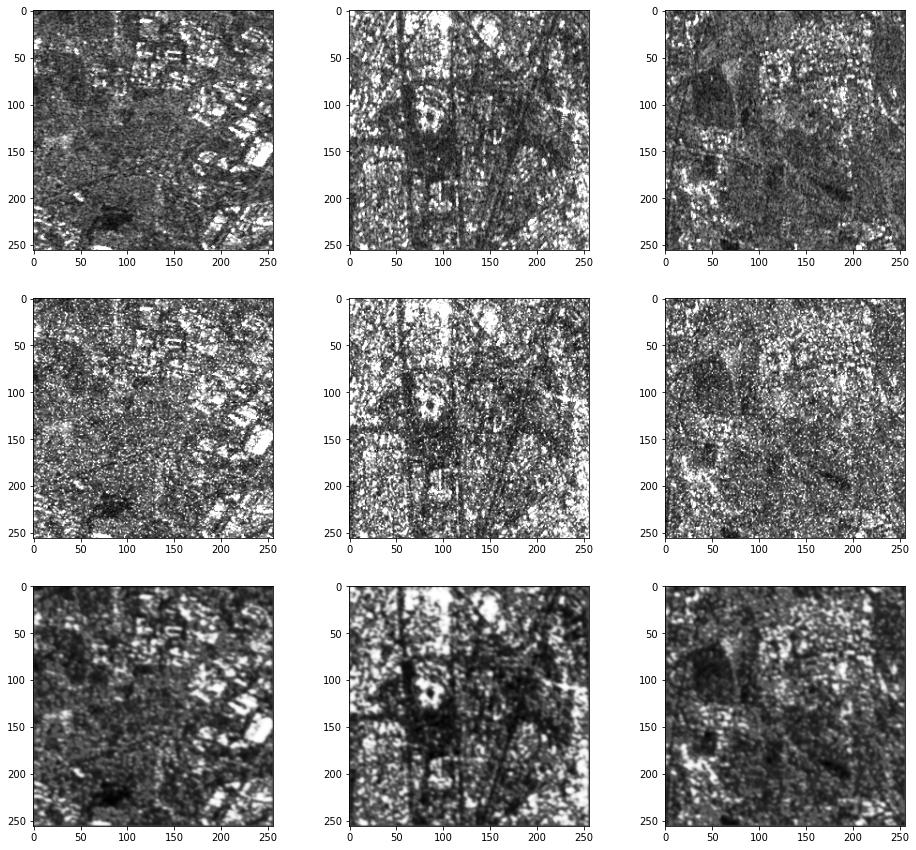

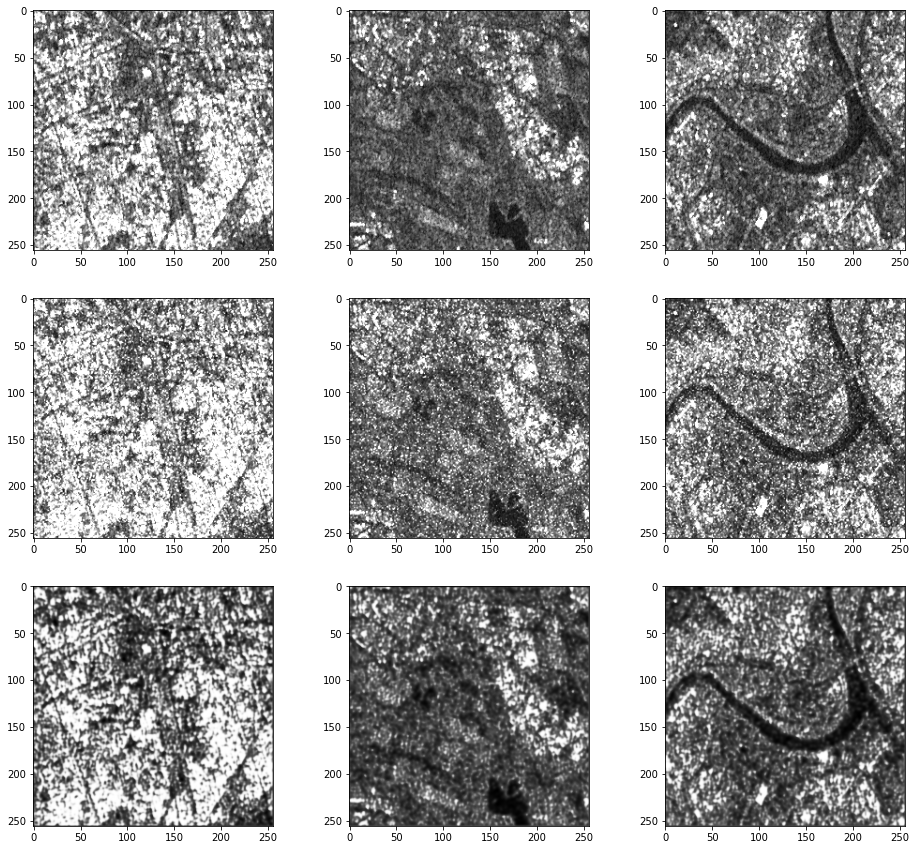

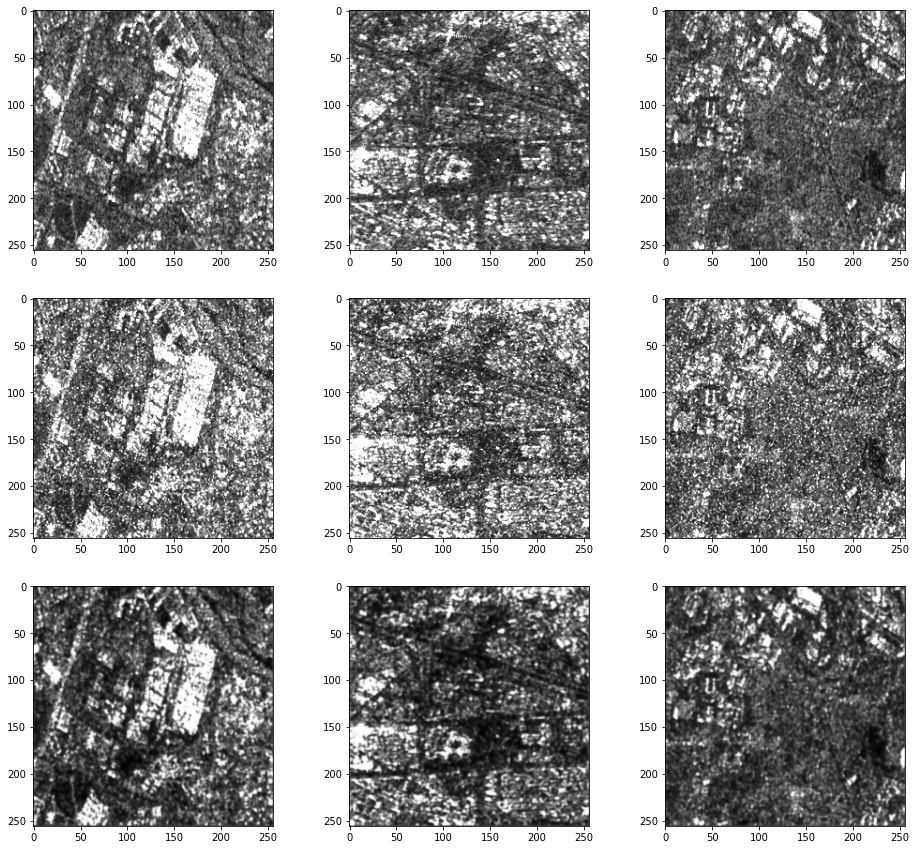

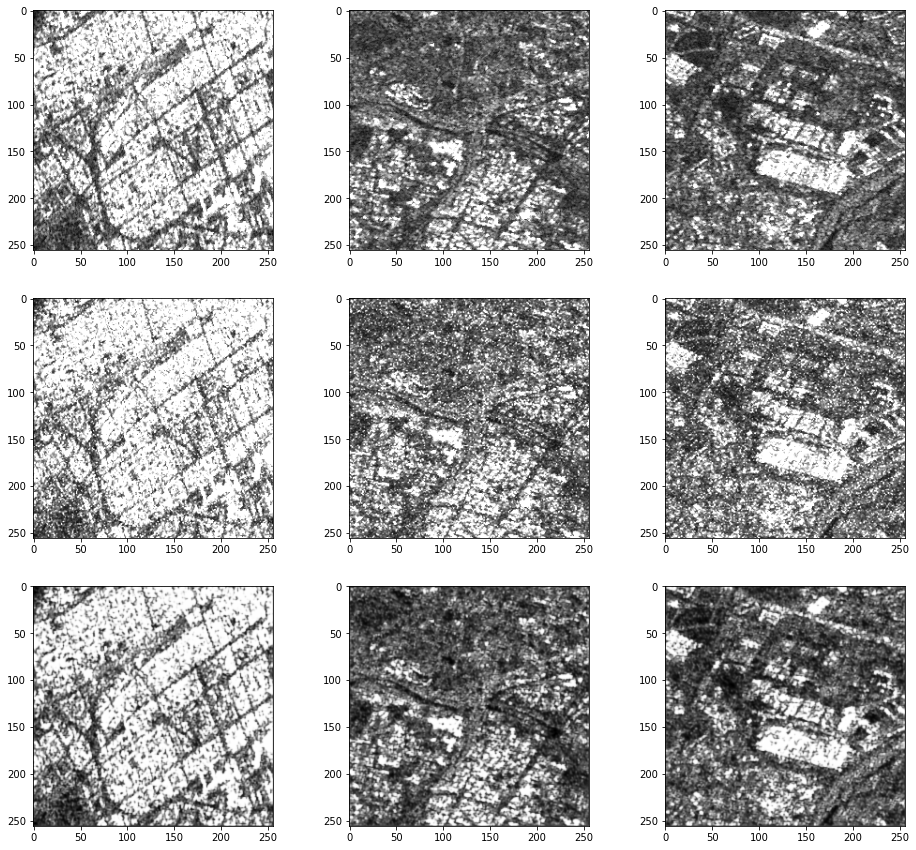

In [19]:
for k in range(0, epochs, 2):
    plt.figure(figsize=(50, 15))
    plt.gray()
    imgs_noiseless = outputlist[k][1].cpu().detach().numpy()
    imgs_noisy = outputlist[k][2].cpu().detach().numpy()
    recon = outputlist[k][3].cpu().detach().numpy()
    for i, item in enumerate(imgs_noiseless):
        if i >= 3: break
        plt.subplot(3, 9, i+1)
        item = item.reshape(-1, 256,256) # -> use for Autoencoder_Linear
        # noisy = noisy.reshape(-1, 256,256) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(imgs_noisy):
        if i >= 3: break
        plt.subplot(3, 9, 9+i+1)
        item = item.reshape(-1, 256,256) # -> use for Autoencoder_Linear
        # noisy = noisy.reshape(-1, 256,256) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 3: break
        plt.subplot(3, 9, 18+i+1) # row_length + i + 1
        item = item.reshape(-1, 256,256) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [20]:
test_output = []
with torch.no_grad():
    loss = 0
    for noiseless_imgs, noisy_imgs in test_loader:
        # load it to the active device
        noiseless_imgs = noiseless_imgs.to(device)
        noisy_imgs = noisy_imgs.to(device)
        
        # compute reconstructions
        outputs = model(noisy_imgs)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, noiseless_imgs)
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        test_output.append([noiseless_imgs,noisy_imgs,outputs])
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("loss = {:.6f}".format(loss))

loss = 0.069495


IndexError: list index out of range

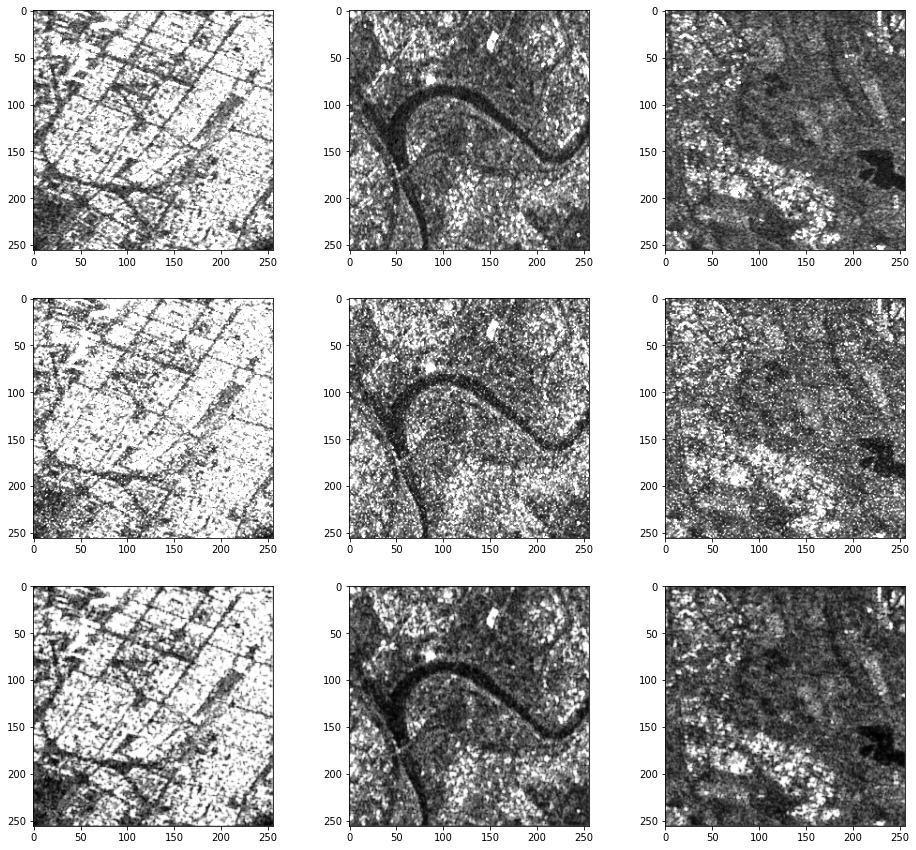

<Figure size 3600x1080 with 0 Axes>

In [21]:
for k in range(0, epochs, 4):
    plt.figure(figsize=(50, 15))
    plt.gray()
    imgs_noiseless = test_output[k][0].cpu().detach().numpy()
    imgs_noisy = test_output[k][1].cpu().detach().numpy()
    recon = test_output[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs_noiseless):
        if i >= 3: break
        plt.subplot(3, 9, i+1)
        item = item.reshape(-1, 256,256)
        plt.imshow(item[0])

    for i, item in enumerate(imgs_noisy):
        if i >= 3: break
        plt.subplot(3, 9, 9+i+1)
        item = item.reshape(-1, 256,256)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 3: break
        plt.subplot(3, 9, 18+i+1) # row_length + i + 1
        item = item.reshape(-1, 256,256)
        plt.imshow(item[0])

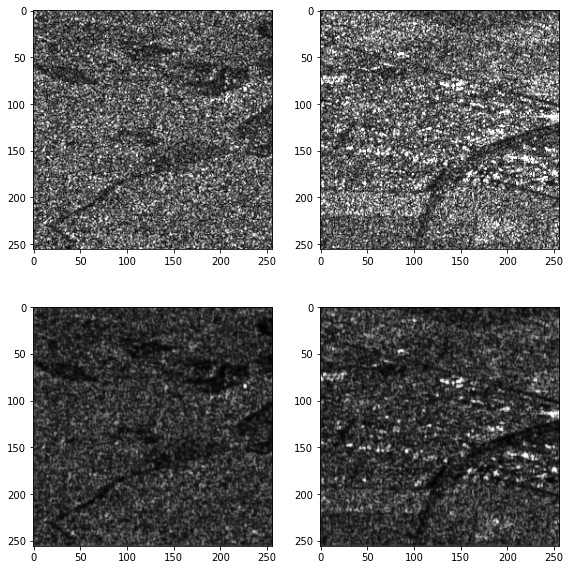

In [22]:
class SAR_TestOutside_Dataset(Dataset):

    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.main_dir = "./data2"
        self.outside_directory_clean_clones = "/outside_set/"
        self.noisy_test = ""
        self.df_test = pd.read_csv(self.main_dir+"/dataset_mapping_outside.csv", sep=',', usecols=['noiseless', 'noisy'])

    def __getitem__(self, index):
        noiseless_test = Image.open(self.main_dir+self.outside_directory_clean_clones+self.df_test.iloc[index]["noiseless"])
        noiseless_test = self.transform(noiseless_test)
        return noiseless_test, noiseless_test

    def __len__(self):
        return len(self.df_test)

outside_dataset = SAR_TestOutside_Dataset()

outside_loader = torch.utils.data.DataLoader(
    outside_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True, 
)

outside_output = []
with torch.no_grad():
    loss = 0
    for noiseless_imgs,_ in outside_loader:
        # load it to the active device
        noiseless_imgs = noiseless_imgs.to(device)
        
        # compute reconstructions
        outputs = model(noiseless_imgs)
                
        # add the mini-batch training loss to epoch loss
        outside_output.append([noiseless_imgs,outputs])
    

for output in outside_output:
    plt.figure(figsize=(30, 10))
    plt.gray()
    imgs_noiseless = output[0].cpu().detach().numpy()
    recon = output[1].cpu().detach().numpy()
    for i, item in enumerate(imgs_noiseless):
        if i >= 3: break
        plt.subplot(2, 6, i+1)
        item = item.reshape(-1, 256,256)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 3: break
        plt.subplot(2, 6, 6+i+1) # row_length + i + 1
        item = item.reshape(-1, 256,256)
        plt.imshow(item[0])

In [10]:
"""
Saving the model if it meets expectations

"""
torch.save(model.state_dict(), "./saved_model_weight/model1")